# Generic PCM Photochemistry postprocessing and visualization demonstrator

This Notebook will show you how to use the Generic PCM photochemistry postprocessing library and how to make interactive visualization with it. For it to work, you'll need to copy the *photochemistry_postprocessing.py* file along this notebook in the directory containing the output file (*diagfi.nc*) as well as the reaction network file chemnetwork/reactfile (to become *reaction.def*).

## Loading simulation and calculating reaction rates

If you do not have a simulation with photochemistry at hand, you can download an example file with:    
```
wget https://web.lmd.jussieu.fr/~mmaurice/photochem_example.zip
unzip photochem_example.zip
```

In [1]:
import photochem_postproc as pcpp

sim_path        = './photochem_example'
NetCDF_filename = 'diagfi.nc'

# The simu class is just a wrapper for xr.Dataset
my_sim = pcpp.GPCM_simu(sim_path,NetCDF_filename)

./photochem_example/diagfi.nc loaded, simulations lasts 1.0 sols


Now let's load the chemical network. Notice that unlike in this example, the reaction network is normally located in a ***chemnetwork/reactfile*** file.

In [2]:
my_sim.network = pcpp.network.from_file(my_sim.path+'/network.def')

reaction  no + hv -> n + o seems to be hard-coded. Add it manually if needed.
reaction  co + oh -> co2 + h seems to be hard-coded. Add it manually if needed.


Some reactions' rates are hard-coded and need to be added manually (you should find their rates in *reaction_rate_lib.py*). To do that we first need to define a new reaction and call again **compute_rates** with the new reaction as second argument:

In [3]:
# First load the parametrization for its rate
from reaction_rate_lib import k_CO_OH_to_CO2_H_JPL_2015

# Then create the reaction objet (here for the reaction co + oh -> co2 + h):
hard_coded_reaction = pcpp.reaction(['co','oh'],['co2','h'],k_CO_OH_to_CO2_H_JPL_2015)

my_sim.network.append(hard_coded_reaction)

We are now ready to compute the rates (be careful with memory, as it will add 2 4D fields per chemical species, and 2 4D fields per reaction!)

In [4]:
my_sim.compute_rates()

## Now let's do some visualization

### Static visualization
Here we use the built-in visualization methods of the *simu* class.

In [5]:
import matplotlib.pyplot as plt

#### Meridional slice

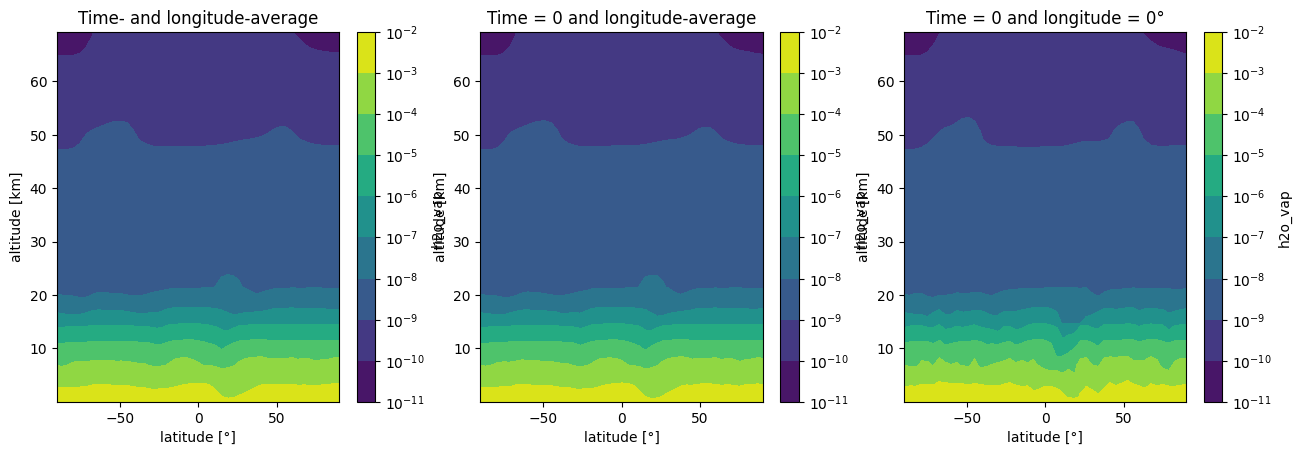

In [6]:
plt.subplot(131)
my_sim.plot_meridional_slice('h2o_vap',logcb=True)
plt.title('Time- and longitude-average')

plt.subplot(132)
my_sim.plot_meridional_slice('h2o_vap',logcb=True,t=0)
plt.title('Time = 0 and longitude-average')

plt.subplot(133)
my_sim.plot_meridional_slice('h2o_vap',logcb=True,t=0,lon=0)
plt.title('Time = 0 and longitude = 0°')

plt.subplots_adjust(right=2)

#### Time evolution

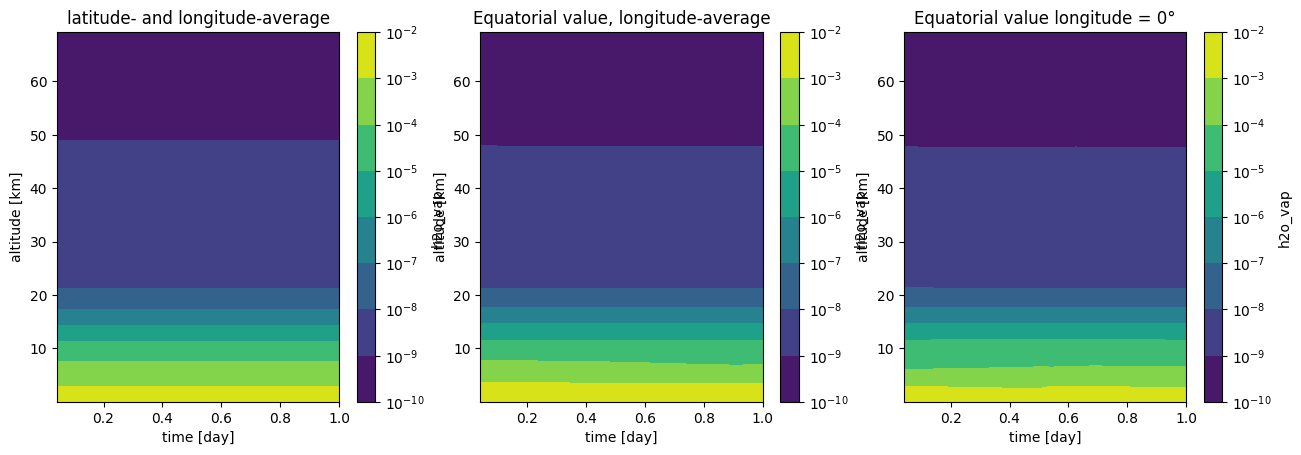

In [7]:
plt.subplot(131)
my_sim.plot_time_evolution('h2o_vap',logcb=True)
plt.title('latitude- and longitude-average')

plt.subplot(132)
my_sim.plot_time_evolution('h2o_vap',logcb=True,lat=0)
plt.title('Equatorial value, longitude-average')

plt.subplot(133)
my_sim.plot_time_evolution('h2o_vap',logcb=True,lat=0,lon=0)
plt.title('Equatorial value longitude = 0°')

plt.subplots_adjust(right=2)

#### Vertical profiles

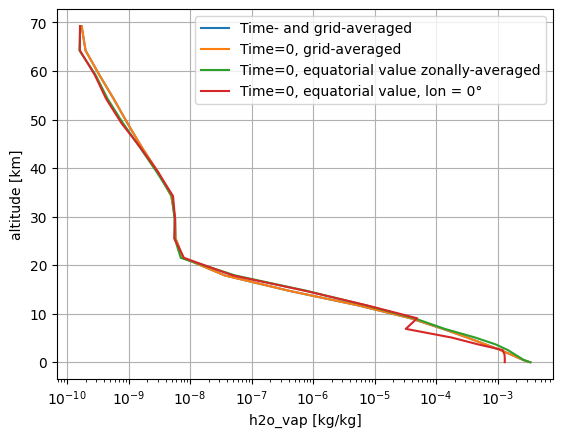

In [8]:
my_sim.plot_profile('h2o_vap',logx=True,label='Time- and grid-averaged')
my_sim.plot_profile('h2o_vap',t=0,logx=True,label='Time=0, grid-averaged')
my_sim.plot_profile('h2o_vap',t=0,lat=0,logx=True,label='Time=0, equatorial value zonally-averaged')
my_sim.plot_profile('h2o_vap',t=0,lat=0,lon=0,logx=True,label='Time=0, equatorial value, lon = 0°')
plt.legend()
plt.grid()

## Interactive visualization
Now we go fancy!

#### Define widgets
Let's define some widgets (see [here](https://ipywidgets.readthedocs.io/en/latest/) for documenttion on jupyter's widgets):

In [9]:
import ipywidgets as widgets

# Coordinates
w_lat = widgets.FloatSlider(min=-90, max=90, step=1, description="latitude")
w_lon = widgets.FloatSlider(min=-180, max=180, step=1, description="longitude")
w_alt = widgets.FloatSlider(min=0, max=max(my_sim.data["altitude"]), step=1, description="altitude")
w_time = widgets.FloatSlider(min=0, max=max(my_sim["Time"]), step=0.1, description="time")

# Fields
w_single_sp   = widgets.Select(options=my_sim.network.species, value="h2o_vap", description="species")
w_multiple_sp = widgets.SelectMultiple(options=my_sim.network.species, value=["h2o_vap"], description="species")
w_reactions   = widgets.SelectMultiple(options=my_sim.network.reactions.keys(), value=["co2 + hv -> co + o"], description="reactions")

# Miscelaneous
w_average = widgets.Checkbox(description='show average')

#### OH meridional slice at various longitudes
OH is a photolysis product with a short lifetime, so it exist only on the dayside. Scrolling through the longitudes will exhibit this dichotomy.

In [10]:
# Slice plotting unction
def make_slice(lon):
    my_sim.plot_meridional_slice('oh',t=0,lon=lon,logcb=True)

# Define interactive output
out = widgets.interactive_output(make_slice,{'lon':w_lon})

# Build the output frame
widgets.VBox([w_lon,out])

#### Water vapor atlas
We can have several action widgets

In [11]:
# Atlas plotting function
def make_atlas(t,alt):
    my_sim.plot_atlas('h2o_vap',t=t,alt=alt)
    plt.title('t='+str(int(t))+' sol, altitude='+str(int(alt))+' km')

# Define interactive output
out = widgets.interactive_output(make_atlas,{'t':w_time,'alt':w_alt})

# Build the output frame
widgets.VBox([w_time,w_alt,out])

#### Temperature profile at various times and locations

In [12]:
# Profile plotting unction
def make_prof(t,lon,lat,avg):
    my_sim.plot_profile('temp',t=t,lon=lon,lat=lat,label='lon='+str(int(lon))+'°, lat='+str(int(lat))+'°')
    if avg:
        my_sim.plot_profile('temp',t=t,label='average')
    plt.legend()
    plt.grid()

# Define interactive output
out = widgets.interactive_output(make_prof,{'t':w_time,'lon':w_lon,'lat':w_lat,'avg':w_average})

# Build the output frame
widgets.HBox([widgets.VBox([w_time,w_lon,w_lat,w_average]),out])

#### Extensive species visualizer
Combining the above examples for arbitrary species

In [13]:
def make_visualizer(sp,t,alt):
    
    plt.subplot(131) # zonal average
    my_sim.plot_meridional_slice(sp,t=t,logcb=True)
    plt.plot([-90,90],[alt,alt],ls='--',lw=3,c='white')

    plt.subplot(132) # atlas
    my_sim.plot_atlas(sp,t=t,alt=alt)
    plt.title('t='+str(int(t))+' sol, altitude='+str(int(alt))+' km')

    plt.subplot(133) # profile
    my_sim.plot_profile('temp',t=t)
    plt.grid()

    plt.subplots_adjust(right=2)

out = widgets.interactive_output(make_visualizer,{'sp':w_single_sp,'t':w_time,'alt':w_alt})

widgets.HBox([widgets.VBox([w_single_sp,w_time,w_alt]),out])

#### Multi-species profiles
Shift+click to select multiple species (Command+click on Mac)

In [14]:
cmap = plt.get_cmap("tab10")
def make_sp_prof(sps,t,lon,lat,avg):

    for i,sp in enumerate(sps):
        my_sim.plot_profile(sp,t=t,lon=lon,lat=lat,logx=True,label=sp,c=cmap(i))
        if avg:
            my_sim.plot_profile(sp,t=t,logx=True,c=cmap(i),ls='--')
    if avg: # just for the legend
        plt.plot([],[],c='k',label='lon='+str(int(lon))+'°, lat='+str(int(lat))+'°')
        plt.plot([],[],ls='--',c='k',label='average')
        
    plt.legend()
    plt.grid()

out = widgets.interactive_output(make_sp_prof,{'sps':w_multiple_sp,'t':w_time,'lon':w_lon,'lat':w_lat,'avg':w_average})

widgets.HBox([widgets.VBox([w_multiple_sp,w_time,w_lon,w_lat,w_average]),out])

#### Species-specific reaction rates

In [15]:
def make_reaction_rate_viz(sp,t):

    for r in my_sim.network.get_subnetwork({'species':[sp]}):
        if sp in r.products:
            my_sim.plot_profile('rate ('+r.formula+')',t=t,logx=True,label=r.formula)
        elif sp in r.reactants:
            my_sim.plot_profile('rate ('+r.formula+')',t=t,logx=True,ls='--',label=r.formula)

    plt.legend()
    plt.grid()

out=widgets.interactive_output(make_reaction_rate_viz,{'sp':w_single_sp,'t':w_time})

widgets.HBox([widgets.VBox([w_single_sp,w_time]),out])

#### Profile with atlas locator
Here the atlas shows the column mass

In [16]:
def make_sp_prof_atlas(sps,t,lon,lat,avg):

    plt.subplot(121) # Vertical profile
    for i,sp in enumerate(sps):
        my_sim.plot_profile(sp,t=t,lon=lon,lat=lat,logx=True,label=sp,c=cmap(i))
        if avg:
            my_sim.plot_profile(sp,t=t,logx=True,c=cmap(i),ls='--')
    if avg: # just for the legend
        plt.plot([],[],c='k',label='lon='+str(int(lon))+'°, lat='+str(int(lat))+'°')
        plt.plot([],[],ls='--',c='k',label='average')

    plt.legend()
    plt.grid()

    plt.subplot(122) # Atlas
    my_sim.plot_atlas(sp+'_col',t=t)
    plt.scatter([lon],[lat],marker='o',s=[100],c=['tab:red'])

    plt.subplots_adjust(right=2)

out = widgets.interactive_output(make_sp_prof_atlas,{'sps':w_multiple_sp,'t':w_time,'lon':w_lon,'lat':w_lat,'avg':w_average})

widgets.HBox([widgets.VBox([w_multiple_sp,w_time,w_lon,w_lat,w_average]),out])

#### Species-specific reaction rates with atlas locator

In [17]:
def make_sp_rate_atlas(sp,t,lon,lat,avg):
        
    plt.subplot(121) # Vertical profile
    for r in my_sim.network:
        if sp in r.products:
            my_sim.plot_profile('rate ('+r.formula+')',t=t,lon=lon if not avg else 'avg',lat=lat if not avg else 'avg',logx=True,label=r.formula)
        elif sp in r.reactants:
            my_sim.plot_profile('rate ('+r.formula+')',t=t,lon=lon if not avg else 'avg',lat=lat if not avg else 'avg',logx=True,ls='--',label=r.formula)
        
    plt.legend()
    plt.grid()

    plt.subplot(122) # Atlas
    my_sim.plot_atlas(sp+'_col',t=t)
    plt.scatter([lon],[lat],marker='o',s=[100],c=['tab:red'])

    plt.subplots_adjust(right=1.5)

out = widgets.interactive_output(make_sp_rate_atlas,{'sp':w_single_sp,'t':w_time,'lon':w_lon,'lat':w_lat,'avg':w_average})

widgets.HBox([widgets.VBox([w_single_sp,w_time,w_lon,w_lat,w_average]),out])

## Chemical network processing

### Working with other formats

We can import and export chemical network from and into various formats, not only Generic-PCM style.

In [18]:
# Let's export our simulation's network into a file readable by the VULCAN model
my_sim.network.to_file('photochem_example/VULCAN_network.txt',format='vulcan')

co + oh -> co2 + h has a custom reaction constant: add it manually
o2 + hv -> o + o is a photolysis: you need to add the branching ratio manually
o2 + hv -> o + o1d is a photolysis: you need to add the branching ratio manually
o3 + hv -> o2 + o1d is a photolysis: you need to add the branching ratio manually
o3 + hv -> o2 + o is a photolysis: you need to add the branching ratio manually
h2o2 + hv -> oh + oh is a photolysis: you need to add the branching ratio manually
h2o_vap + hv -> h + oh is a photolysis: you need to add the branching ratio manually
co2 + hv -> co + o is a photolysis: you need to add the branching ratio manually
co2 + hv -> co + o1d is a photolysis: you need to add the branching ratio manually
ho2 + hv -> oh + o is a photolysis: you need to add the branching ratio manually


Some notifications have been issued because one has to manually add some extra informations for some reactions. But you the file ***photochem_example/VULCAN_network.txt*** should have been correctly written, and you can use it to run a VULCAN simulation once you have added the required informations.

### Making subnetwork

We can also use these tools to design and export subnetworks:

In [19]:
# Select by type:
print('Photolysis sub-network:')
print('=======================')
for r in my_sim.network.get_subnetwork({'type':[pcpp.photolysis]}):
    print(r.formula)

# Select by species:
print('')
print('HOx sub-network:')
print('=================')
for r in my_sim.network.get_subnetwork({'species':['h','oh','ho2']}):
    print(r.formula)

# Select by element:
print('')
print('C sub-network:')
print('===============')
for r in my_sim.network.get_subnetwork({'elements':['c']}):
    print(r.formula)

Photolysis sub-network:
o2 + hv -> o + o
o2 + hv -> o + o1d
o3 + hv -> o2 + o1d
o3 + hv -> o2 + o
h2o2 + hv -> oh + oh
h2o_vap + hv -> h + oh
co2 + hv -> co + o
co2 + hv -> co + o1d
ho2 + hv -> oh + o

HOx sub-network:
h2o2 + hv -> oh + oh
h2o_vap + hv -> h + oh
ho2 + hv -> oh + o
o1d + h2o_vap -> oh + oh
o1d + h2 -> oh + h
o + h2 -> oh + h
o + ho2 -> oh + o2
o + oh -> o2 + h
h + o3 -> oh + o2
h + ho2 -> oh + oh
h + ho2 -> h2 + o2
h + ho2 -> h2o_vap + o
oh + ho2 -> h2o_vap + o2
oh + h2o2 -> h2o_vap + ho2
oh + h2 -> h2o_vap + h
o + h2o2 -> oh + ho2
oh + o3 -> ho2 + o2
ho2 + o3 -> oh + o2 + o2
ho2 + ho2 -> h2o2 + o2
oh + oh -> h2o_vap + o
h + o2 + M -> ho2 + M
h + oh + M -> h2o_vap + M
oh + oh + M -> h2o2 + M
h + h + M -> h2 + M
ho2 + ho2 + M -> h2o2 + o2 + M
co + oh -> co2 + h

C sub-network:
co2 + hv -> co + o
co2 + hv -> co + o1d
o1d + co -> o + co
o1d + co2 -> o + co2
co + o + M -> co2 + M
co + oh -> co2 + h


### Exporting custom subnetwork
You can make your own custom chemical network (ideally selecting reactions from a large database - here we just work with our original simulation's reduced network). You may want to save the associated ***traceur.def*** file (notice that you'll have to add manually parameters, but at least you won't forget tracers.)

In [20]:
from ipywidgets import Layout

def select_reactions(reactions,net_filename,trac_filename,format):
    save_network_button = widgets.Button(description='Save reactfile')
    save_tracers_button = widgets.Button(description='Save tracfile')
    
    def on_save_network_button_clicked(b):
        to_save = pcpp.network()
        for r in reactions:
            to_save.append(my_sim.network[r])
        to_save.to_file(net_filename,format=format)
        
    def on_save_tracers_button_clicked(b):
        to_save = pcpp.network()
        for r in reactions:
            to_save.append(my_sim.network[r])
        to_save.save_traceur_file(trac_filename)
        
    save_network_button.on_click(on_save_network_button_clicked)
    save_tracers_button.on_click(on_save_tracers_button_clicked)
    display(save_network_button, widgets.Output())
    display(save_tracers_button, widgets.Output())
    
w_reactions         = widgets.SelectMultiple(options=my_sim.network.reactions.keys(),layout=Layout(height='400px'))
w_network_filename  = widgets.Text(value='photochem_example/my_custom_network.def',description='network filename:',disabled=False)
w_tracers_filename  = widgets.Text(value='photochem_example/my_custom_traceur.def',description='tracers filename:',disabled=False)
w_format            = widgets.Select(options=['GPCM','vulcan'],value='GPCM',description='format:')

out = widgets.interactive_output(select_reactions,{'reactions':w_reactions,'net_filename':w_network_filename,
                                                   'trac_filename':w_tracers_filename,'format':w_format})
widgets.HBox([w_reactions,widgets.VBox([w_format,w_network_filename,w_tracers_filename,out])])